In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, classification_report

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from PIL import Image

In [2]:
# ==============================================================
# PATHS AND PARAMETERS
# ==============================================================
train_dir = r'C:\Users\Server\Documents\retinal-diseases\database\Training_Set\Training_Set\Training'
train_label_csv = r'C:\Users\Server\Documents\retinal-diseases\database\Training_Set\Training_Set\RFMiD_Training_Labels.csv'

BATCH_SIZE = 16
EPOCHS = 5
LR = 1e-4
IMG_SIZE = 224

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==============================================================
# DATA PREPARATION
# ==============================================================
df = pd.read_csv(train_label_csv)
train_df, val_df = np.split(df.sample(frac=1, random_state=42), [int(0.8*len(df))])

C:\Users\Server\AppData\Roaming\Python\Python313\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [3]:
class RetinaDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.image_col = 'ID'
        self.label_cols = self.df.columns[1:]
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = f"{self.df.loc[idx, self.image_col]}.png"
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        labels = torch.tensor(self.df.loc[idx, self.label_cols].values.astype('float32'))
        return image, labels

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [4]:
train_dataset = RetinaDataset(train_df, train_dir, transform)
val_dataset = RetinaDataset(val_df, train_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ==============================================================
# MODEL SETUP
# ==============================================================
num_classes = len(df.columns) - 1
weights = EfficientNet_B0_Weights.DEFAULT
model = efficientnet_b0(weights=weights)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [6]:
# ==============================================================
# TRAINING LOOP
# ==============================================================
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}/{EPOCHS}: train loss={avg_train_loss:.4f}, val loss={avg_val_loss:.4f}")

# Save model
torch.save(model.state_dict(), "5_epochs_efficientnet_retina.pth")
print("\n✅ Model saved as efficientnet_retina.pth")

Epoch 1/5: train loss=0.2058, val loss=0.0958
Epoch 2/5: train loss=0.0864, val loss=0.0781
Epoch 3/5: train loss=0.0719, val loss=0.0705
Epoch 4/5: train loss=0.0634, val loss=0.0648
Epoch 5/5: train loss=0.0564, val loss=0.0617

✅ Model saved as efficientnet_retina.pth


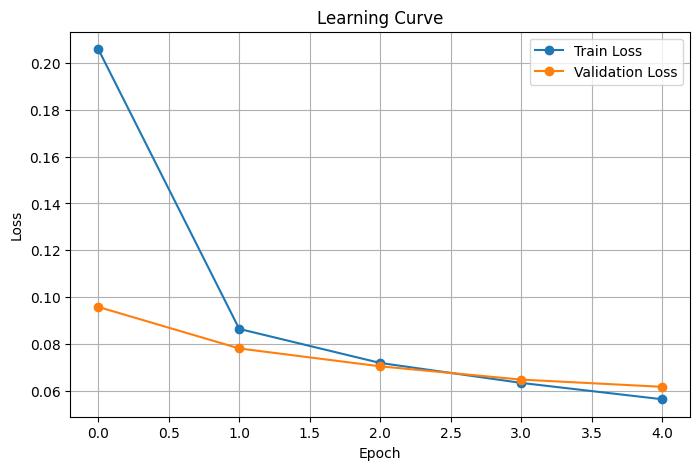

In [7]:
# ==============================================================
# 1️⃣ LEARNING CURVE
# ==============================================================
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='o')
plt.title("Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

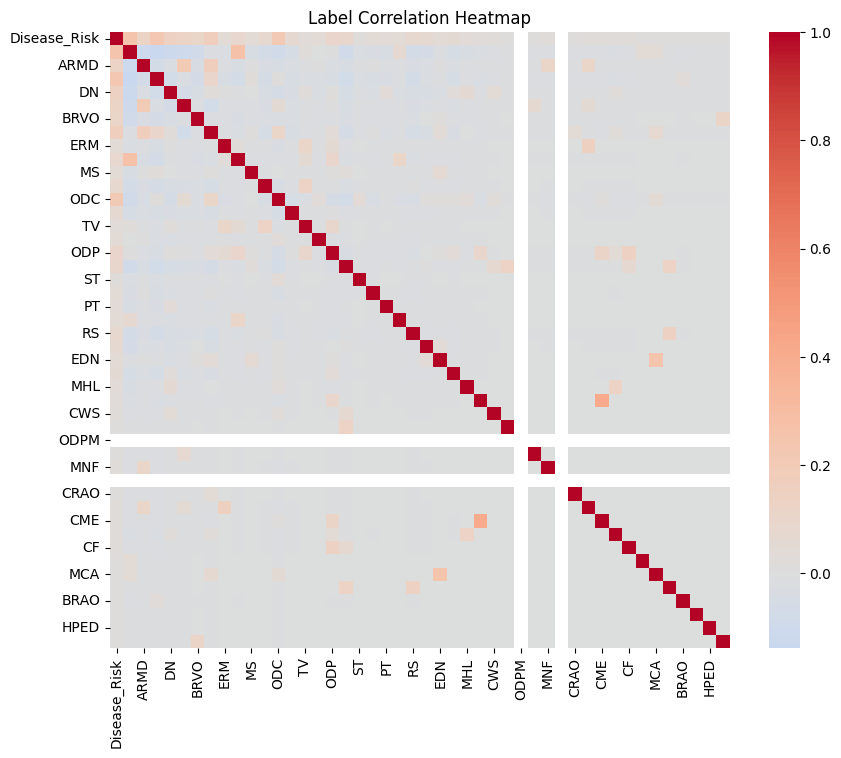

In [8]:
# ==============================================================
# 2️⃣ LABEL CORRELATION HEATMAP
# ==============================================================
plt.figure(figsize=(10,8))
sns.heatmap(df.iloc[:, 1:].corr(), cmap="coolwarm", center=0, annot=False)
plt.title("Label Correlation Heatmap")
plt.show()

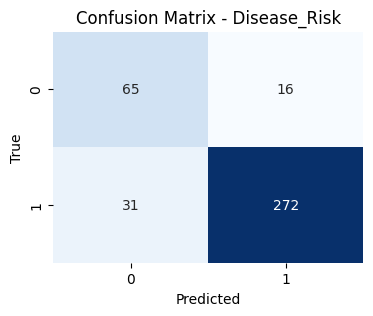

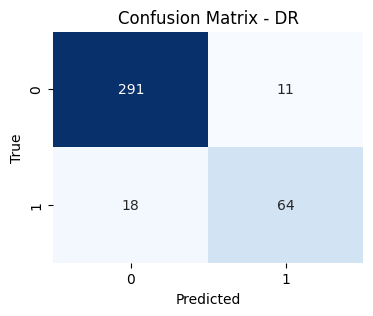

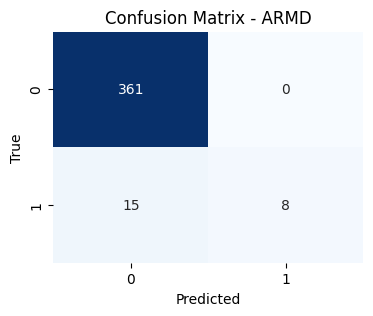

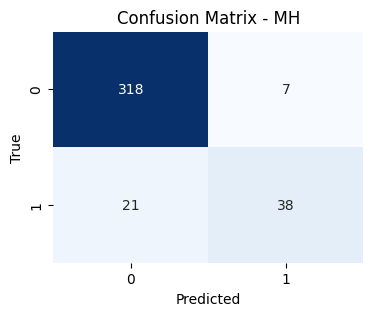

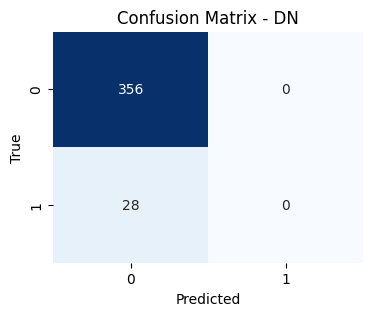

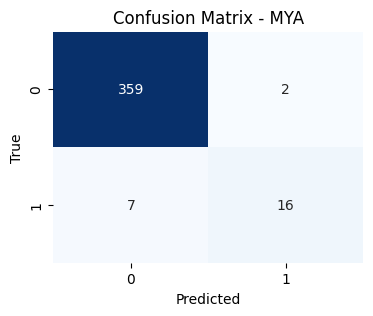

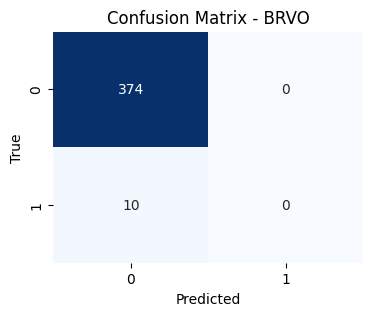

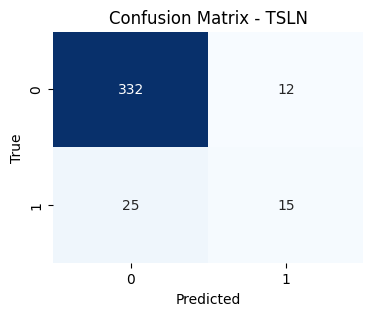

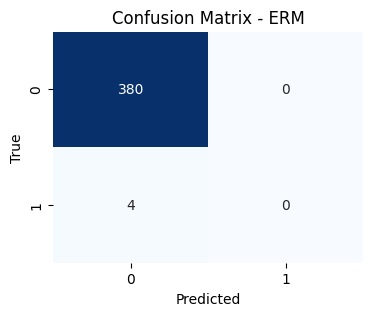

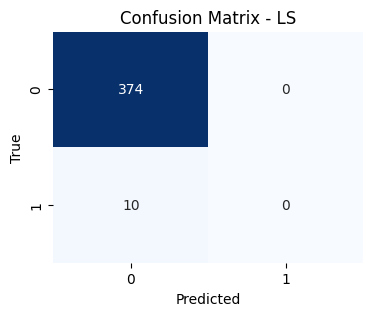

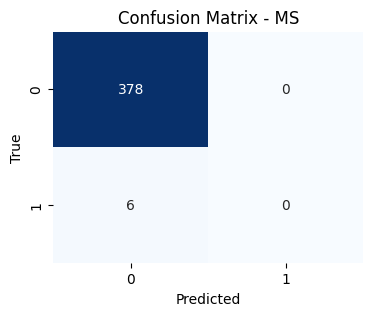

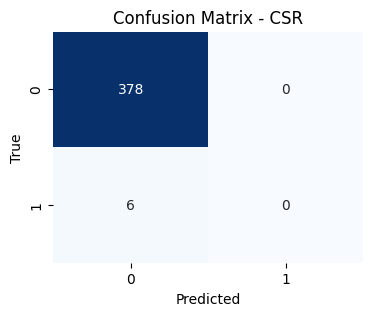

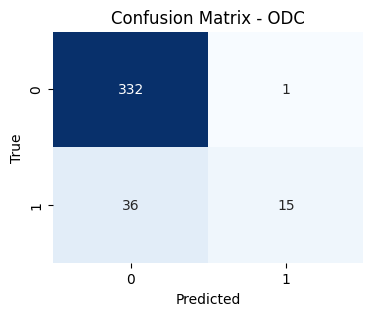

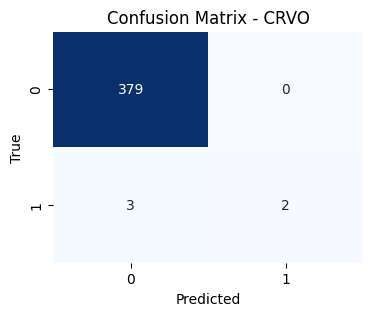

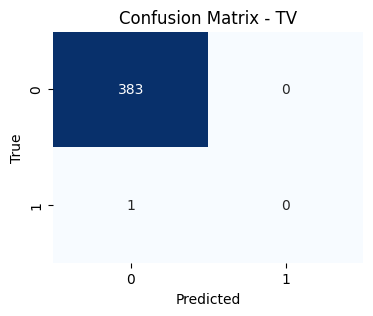

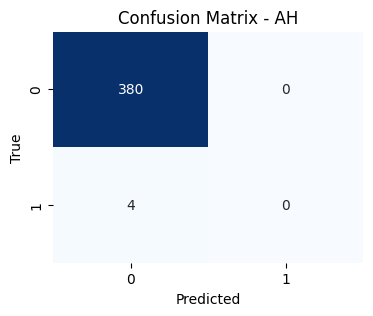

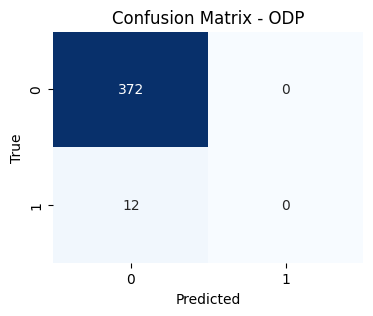

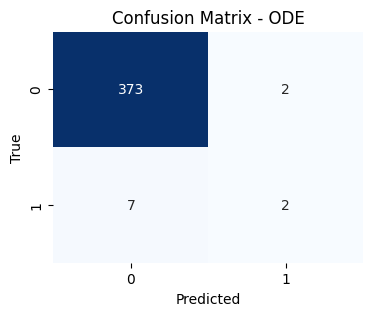

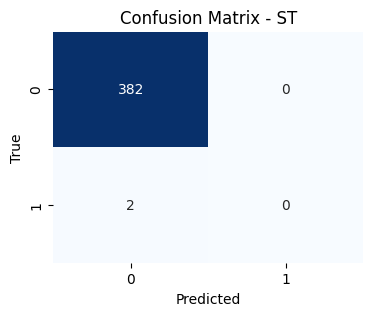

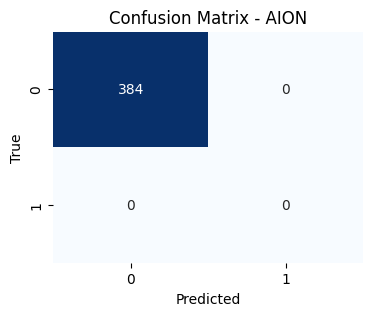

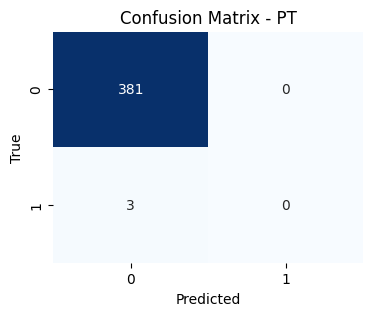

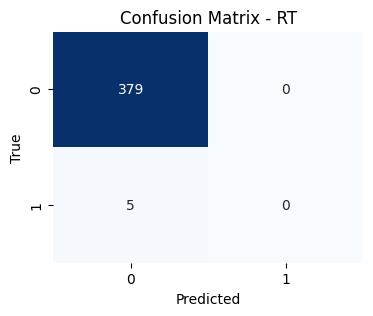

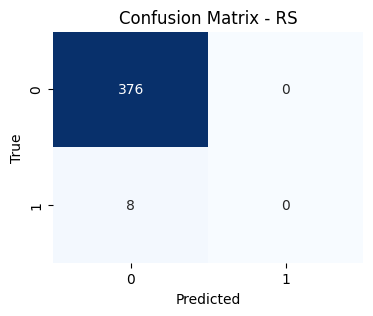

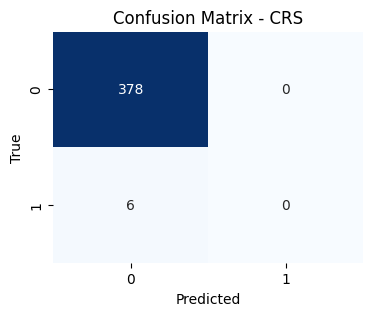

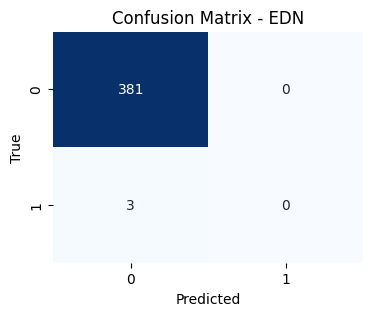

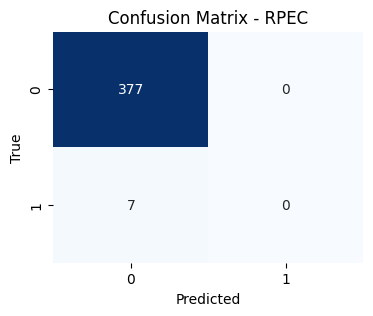

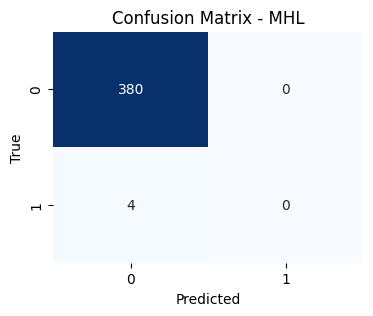

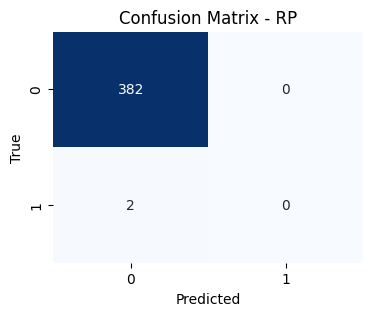

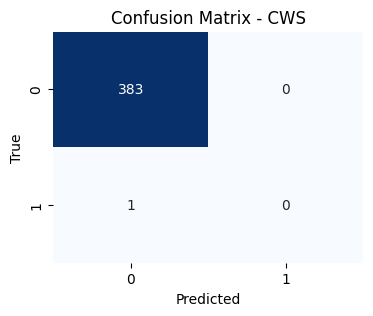

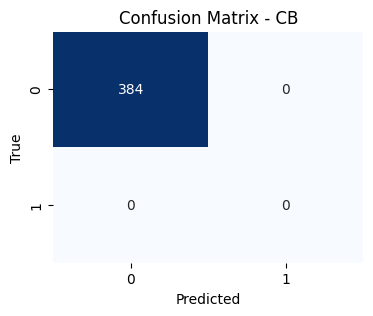

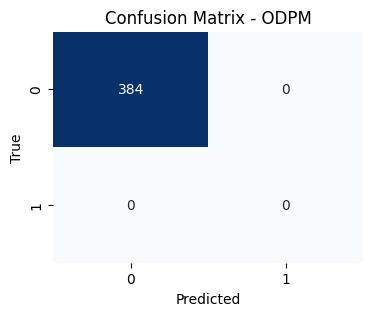

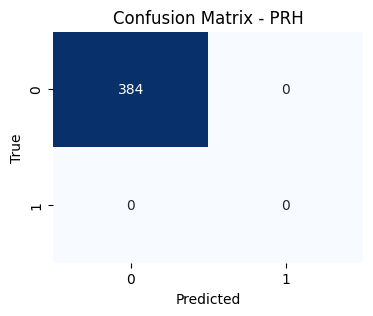

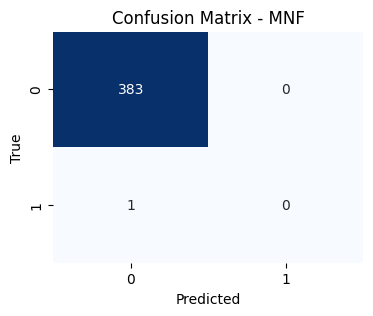

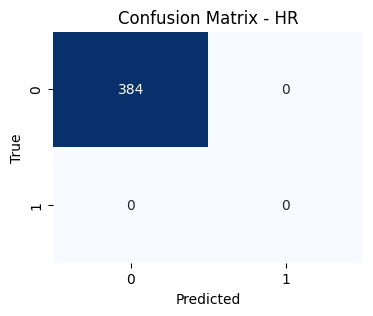

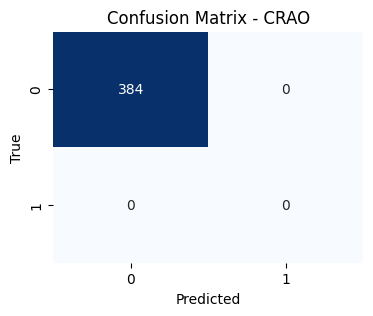

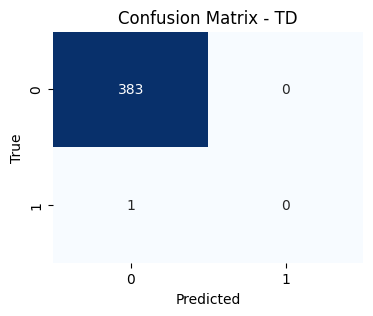

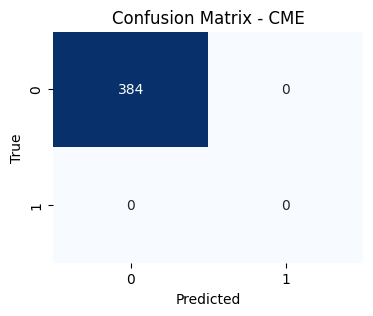

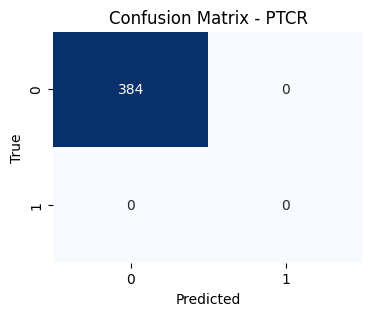

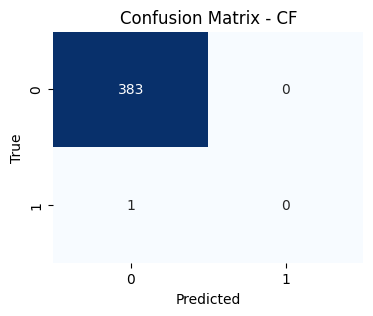

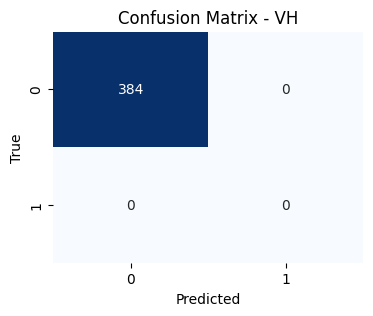

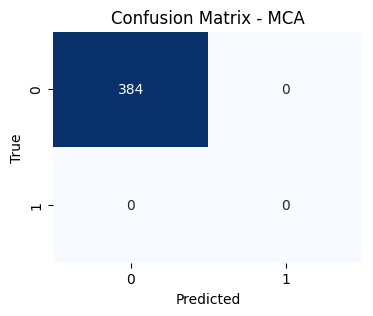

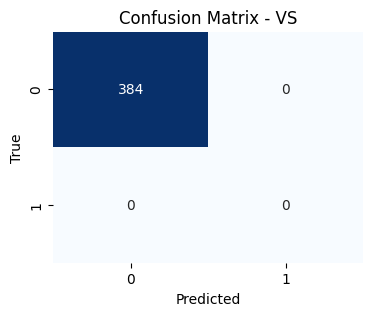

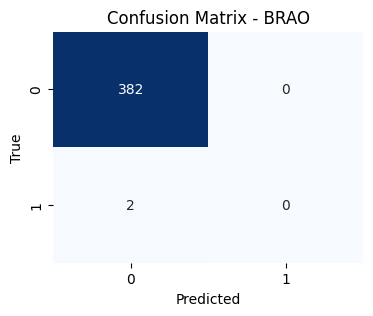

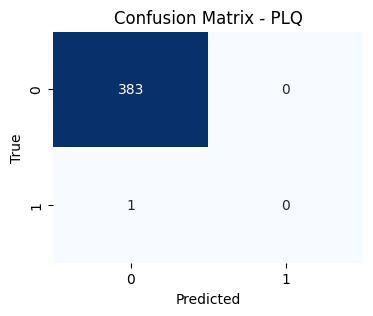

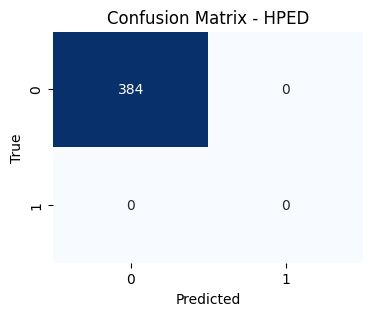

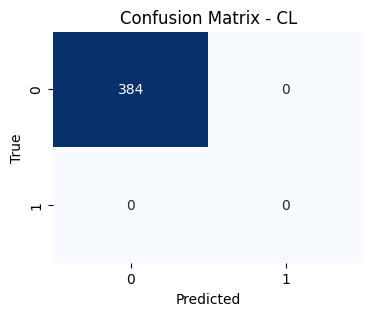


Classification Report (micro/macro avg):
              precision    recall  f1-score   support

Disease_Risk       0.94      0.90      0.92       303
          DR       0.85      0.78      0.82        82
        ARMD       1.00      0.35      0.52        23
          MH       0.84      0.64      0.73        59
          DN       0.00      0.00      0.00        28
         MYA       0.89      0.70      0.78        23
        BRVO       0.00      0.00      0.00        10
        TSLN       0.56      0.38      0.45        40
         ERM       0.00      0.00      0.00         4
          LS       0.00      0.00      0.00        10
          MS       0.00      0.00      0.00         6
         CSR       0.00      0.00      0.00         6
         ODC       0.94      0.29      0.45        51
        CRVO       1.00      0.40      0.57         5
          TV       0.00      0.00      0.00         1
          AH       0.00      0.00      0.00         4
         ODP       0.00      0.00      

In [9]:
# ==============================================================
# 3️⃣ CONFUSION MATRIX (Thresholded Multi-Label)
# ==============================================================
def evaluate_model(model, dataloader, threshold=0.5):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = torch.sigmoid(model(images)).cpu().numpy()
            preds = (outputs > threshold).astype(int)
            y_true.append(labels.numpy())
            y_pred.append(preds)
    return np.vstack(y_true), np.vstack(y_pred)

y_true, y_pred = evaluate_model(model, val_loader)

cm_list = multilabel_confusion_matrix(y_true, y_pred)
label_names = df.columns[1:]

for i, label in enumerate(label_names):
    plt.figure(figsize=(4,3))
    sns.heatmap(cm_list[i], annot=True, fmt='d', cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {label}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

print("\nClassification Report (micro/macro avg):")
print(classification_report(y_true, y_pred, target_names=label_names, zero_division=0))

C:\Users\Server\AppData\Roaming\Python\Python313\site-packages\torch\nn\modules\module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


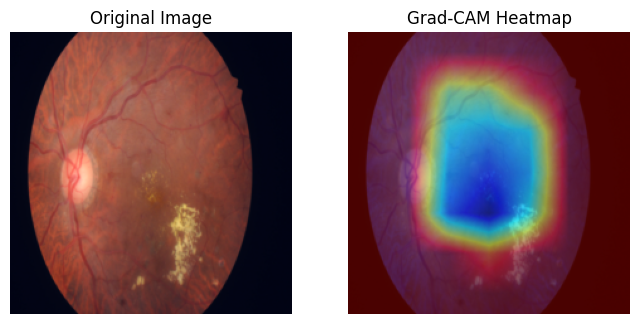

In [10]:
# ==============================================================
# 4️⃣ FEATURE IMPORTANCE USING GRAD-CAM
# ==============================================================
import cv2
from torchvision.utils import make_grid

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook()

    def hook(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx):
        self.model.zero_grad()
        output = self.model(input_tensor)
        class_score = output[0, class_idx]
        class_score.backward()
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = torch.relu(cam)
        cam = cam.squeeze().cpu().numpy()
        cam = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam

# Pick one validation image
sample_img, _ = val_dataset[0]
input_tensor = sample_img.unsqueeze(0).to(device)
target_layer = model.features[-1]
gradcam = GradCAM(model, target_layer)

# Select class index (use top predicted class)
with torch.no_grad():
    output = torch.sigmoid(model(input_tensor))
    class_idx = torch.argmax(output, dim=1).item()

cam = gradcam.generate(input_tensor, class_idx)
image_np = np.transpose(sample_img.numpy(), (1, 2, 0))
image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

# Overlay Grad-CAM heatmap
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
overlay = 0.5 * heatmap + 0.5 * image_np[..., ::-1]

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(image_np)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(overlay)
plt.title("Grad-CAM Heatmap")
plt.axis("off")
plt.show()